In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import norm, randint

In [3]:
!pip install --quiet yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, silhouette_score, pairwise_distances


In [5]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [6]:
!pip install scikit-image
!pip install opencv-python

In [7]:
import os
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage import color

In [8]:
df0 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MLFinal/leaves.csv", header=None)

In [9]:
# Resetting header
columns_names = []
for i in range(df0.shape[1]):
  if i == 0:
    columns_names.append("Leaf_Category")
  elif i == 1:
    columns_names.append("Img_Index")
  else:
    columns_names.append(f"Feature_{i-2}")
df0.columns = columns_names

In [10]:
# Extracting Class Labels
class_labels = set(df0["Leaf_Category"])
class_labels

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36}

In [11]:
df0

,Leaf_Category,Img_Index,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,0.018121,0.006190,0.000265,1.15260


In [12]:
# Define parameters for LBP
radius = 1
n_points = 8 * radius
METHOD = 'uniform'

# Function to extract HOG and LBP features
def extract_features(image):
    # Convert image to grayscale
    gray_image = color.rgb2gray(image)

    # Extract HOG features
    hog_features, hog_image = hog(
        gray_image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        multichannel=False
    )

    # Extract LBP features
    lbp = local_binary_pattern(gray_image, n_points, radius, METHOD)
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize the histogram

    # Extract Color Histogram features (for each channel)
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    hist_features = []
    for (chan, clr) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)

    return hog_features, lbp_hist, hist_features

In [13]:
# Initialize lists to store features and labels
hog_features_list = []
lbp_features_list = []
hist_features_list = []
image_labels_list = []

# Path to the images directory
images_dir = '/content/drive/MyDrive/Colab Notebooks/MLFinal/leaves'

# Read images and extract features
category_list = os.listdir(images_dir)
for dir_name in category_list:
    dot_i = dir_name.index('. ')
    cat_index = int(dir_name[:dot_i])
    if cat_index not in class_labels:
      continue

    category_path = os.path.join(images_dir, dir_name)
    if os.path.isdir(category_path):
        for img_i, img_name in enumerate(os.listdir(category_path)):
            img_path = os.path.join(category_path, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            # Extract features
            hog_features, lbp_features, hist_features = extract_features(image)

            # Append features and label
            hog_features_list.append(hog_features)
            lbp_features_list.append(lbp_features)
            hist_features_list.append(hist_features)
            image_labels_list.append((cat_index, img_i + 1))

In [14]:
# Convert lists to numpy arrays
hog_features_array = np.array(hog_features_list)
lbp_features_array = np.array(lbp_features_list)
hist_features_array = np.array(hist_features_list)
labels_array = np.array(image_labels_list)

# Create a DataFrame with the features and labels
hog_features_df = pd.DataFrame(hog_features_array, columns=['hog_'+str(i) for i in range(hog_features_array.shape[1])])
lbp_features_df = pd.DataFrame(lbp_features_array, columns=['lbp'+str(i) for i in range(lbp_features_array.shape[1])])
hist_features_df = pd.DataFrame(hist_features_array, columns=['hist_'+str(i) for i in range(hist_features_array.shape[1])])
img_labels_df = pd.DataFrame(labels_array, columns=['Leaf_Category', 'Img_Index'])

# Concatenate extracted features
img_features_df = pd.concat([img_labels_df, lbp_features_df], axis=1)

In [15]:
img_features_df = img_features_df.sort_values(['Leaf_Category', 'Img_Index'], ignore_index=True)

In [16]:
img_features_df

,Leaf_Category,Img_Index,lbp0,lbp1,lbp2,lbp3,lbp4,lbp5,lbp6,lbp7,lbp8,lbp9
0,1,1,0.027561,0.067429,0.033870,0.127487,0.121392,0.177015,0.106872,0.081552,0.132872,0.123950
1,1,2,0.028352,0.067567,0.034446,0.126929,0.122591,0.180153,0.106865,0.080466,0.130027,0.122604
2,1,3,0.027062,0.070252,0.029077,0.122241,0.104575,0.174168,0.106722,0.086175,0.147474,0.132255
3,1,4,0.029728,0.073597,0.032444,0.119006,0.103273,0.166819,0.108439,0.086409,0.142263,0.138024
4,1,5,0.028915,0.068578,0.033749,0.126026,0.114907,0.175502,0.106991,0.083772,0.135337,0.126224
...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.038718,0.069433,0.050421,0.129334,0.143908,0.158845,0.106497,0.076236,0.103908,0.122700
336,36,7,0.052257,0.076696,0.061499,0.119271,0.133008,0.133205,0.104010,0.081442,0.098494,0.140119
337,36,8,0.039915,0.071188,0.049936,0.128736,0.139611,0.157663,0.102784,0.077698,0.107771,0.124699
338,36,9,0.031697,0.068396,0.039861,0.126480,0.131509,0.169515,0.110684,0.077212,0.121751,0.122895


In [17]:
df0_img = pd.merge(left=df0, right=img_features_df, how='inner')

In [18]:
df0_img

,Leaf_Category,Img_Index,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,lbp0,lbp1,lbp2,lbp3,lbp4,lbp5,lbp6,lbp7,lbp8,lbp9
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,0.027561,0.067429,0.033870,0.127487,0.121392,0.177015,0.106872,0.081552,0.132872,0.123950
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,0.028352,0.067567,0.034446,0.126929,0.122591,0.180153,0.106865,0.080466,0.130027,0.122604
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0.027062,0.070252,0.029077,0.122241,0.104575,0.174168,0.106722,0.086175,0.147474,0.132255
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0.029728,0.073597,0.032444,0.119006,0.103273,0.166819,0.108439,0.086409,0.142263,0.138024
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0.028915,0.068578,0.033749,0.126026,0.114907,0.175502,0.106991,0.083772,0.135337,0.126224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0.038718,0.069433,0.050421,0.129334,0.143908,0.158845,0.106497,0.076236,0.103908,0.122700
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,0.052257,0.076696,0.061499,0.119271,0.133008,0.133205,0.104010,0.081442,0.098494,0.140119
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0.039915,0.071188,0.049936,0.128736,0.139611,0.157663,0.102784,0.077698,0.107771,0.124699
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,0.031697,0.068396,0.039861,0.126480,0.131509,0.169515,0.110684,0.077212,0.121751,0.122895


In [19]:
df0.describe()

,Leaf_Category,Img_Index,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,18.544118,6.282353,0.719854,2.440210,0.513760,0.904158,0.943793,0.531234,0.037345,0.523845,0.051346,0.124535,0.017670,0.005928,0.000387,1.162630
std,11.152514,3.462779,0.208311,2.599043,0.195583,0.114639,0.115047,0.217532,0.038575,1.039639,0.035965,0.051860,0.013755,0.005294,0.000431,0.584854
min,1.000000,1.000000,0.117080,1.006600,0.107610,0.485490,0.396490,0.078376,0.002837,0.001464,0.005022,0.033415,0.001115,0.000229,0.000007,0.169400
25%,9.000000,3.000000,0.550623,1.211300,0.349623,0.890667,0.966230,0.346818,0.009521,0.016500,0.022843,0.083362,0.006901,0.002080,0.000102,0.718900
50%,15.000000,6.000000,0.763450,1.570750,0.501855,0.948130,0.992980,0.579160,0.023860,0.103615,0.042087,0.119375,0.014050,0.004447,0.000239,1.077450
75%,29.000000,9.000000,0.895097,2.343100,0.633373,0.976897,1.000000,0.700713,0.047834,0.416432,0.073046,0.163795,0.026127,0.008307,0.000516,1.554575
max,36.000000,16.000000,0.998710,19.038000,0.948340,0.993880,1.000000,0.858160,0.198980,7.206200,0.190670,0.280810,0.073089,0.029786,0.002936,2.708500


In [20]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Leaf_Category  340 non-null    int64  
 1   Img_Index      340 non-null    int64  
 2   Feature_0      340 non-null    float64
 3   Feature_1      340 non-null    float64
 4   Feature_2      340 non-null    float64
 5   Feature_3      340 non-null    float64
 6   Feature_4      340 non-null    float64
 7   Feature_5      340 non-null    float64
 8   Feature_6      340 non-null    float64
 9   Feature_7      340 non-null    float64
 10  Feature_8      340 non-null    float64
 11  Feature_9      340 non-null    float64
 12  Feature_10     340 non-null    float64
 13  Feature_11     340 non-null    float64
 14  Feature_12     340 non-null    float64
 15  Feature_13     340 non-null    float64
dtypes: float64(14), int64(2)
memory usage: 42.6 KB


In [21]:
df0.value_counts()

Leaf_Category  Img_Index  Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  Feature_13
1              1          0.72694    1.4742     0.32396    0.98535    1.00000    0.835920   0.004657   0.003947   0.047790   0.127950   0.016108    0.005232    0.000275    1.17560       1
26             9          0.87402    2.0754     0.55373    0.96281    0.98421    0.564480   0.019656   0.070316   0.037553   0.109460   0.011839    0.003850    0.000214    1.06930       1
27             5          0.79923    1.6549     0.40919    0.98964    1.00000    0.815000   0.004897   0.004364   0.028693   0.091008   0.008214    0.002501    0.000136    0.98834       1
               4          0.72719    1.4779     0.32980    0.99388    1.00000    0.842300   0.002967   0.001602   0.026340   0.081903   0.006663    0.001785    0.000194    0.98050       1
               3          0.81380    1.7370     0.42956    0.9895

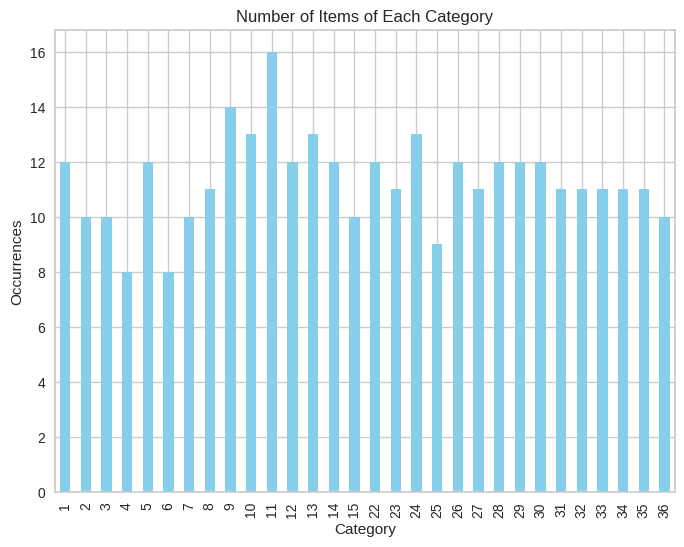

In [22]:
# Count the occurrences of each value in the column 'Feature1'
cat_len = df0["Leaf_Category"].value_counts()

# Plot the occurrences
plt.figure(figsize=(8, 6))
cat_len.sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Occurrences')
plt.title('Number of Items of Each Category')
plt.show()

In [41]:
X = df0_img.drop(columns=["Leaf_Category", "Img_Index"])
y = df0_img["Leaf_Category"]

Xcsv = df0.drop(columns=["Leaf_Category", "Img_Index"])

In [42]:
y.value_counts()

Leaf_Category
11    16
9     14
13    13
24    13
10    13
1     12
30    12
29    12
28    12
26    12
14    12
22    12
12    12
5     12
23    11
27    11
8     11
31    11
32    11
33    11
34    11
35    11
15    10
2     10
7     10
3     10
36    10
25     9
6      8
4      8
Name: count, dtype: int64

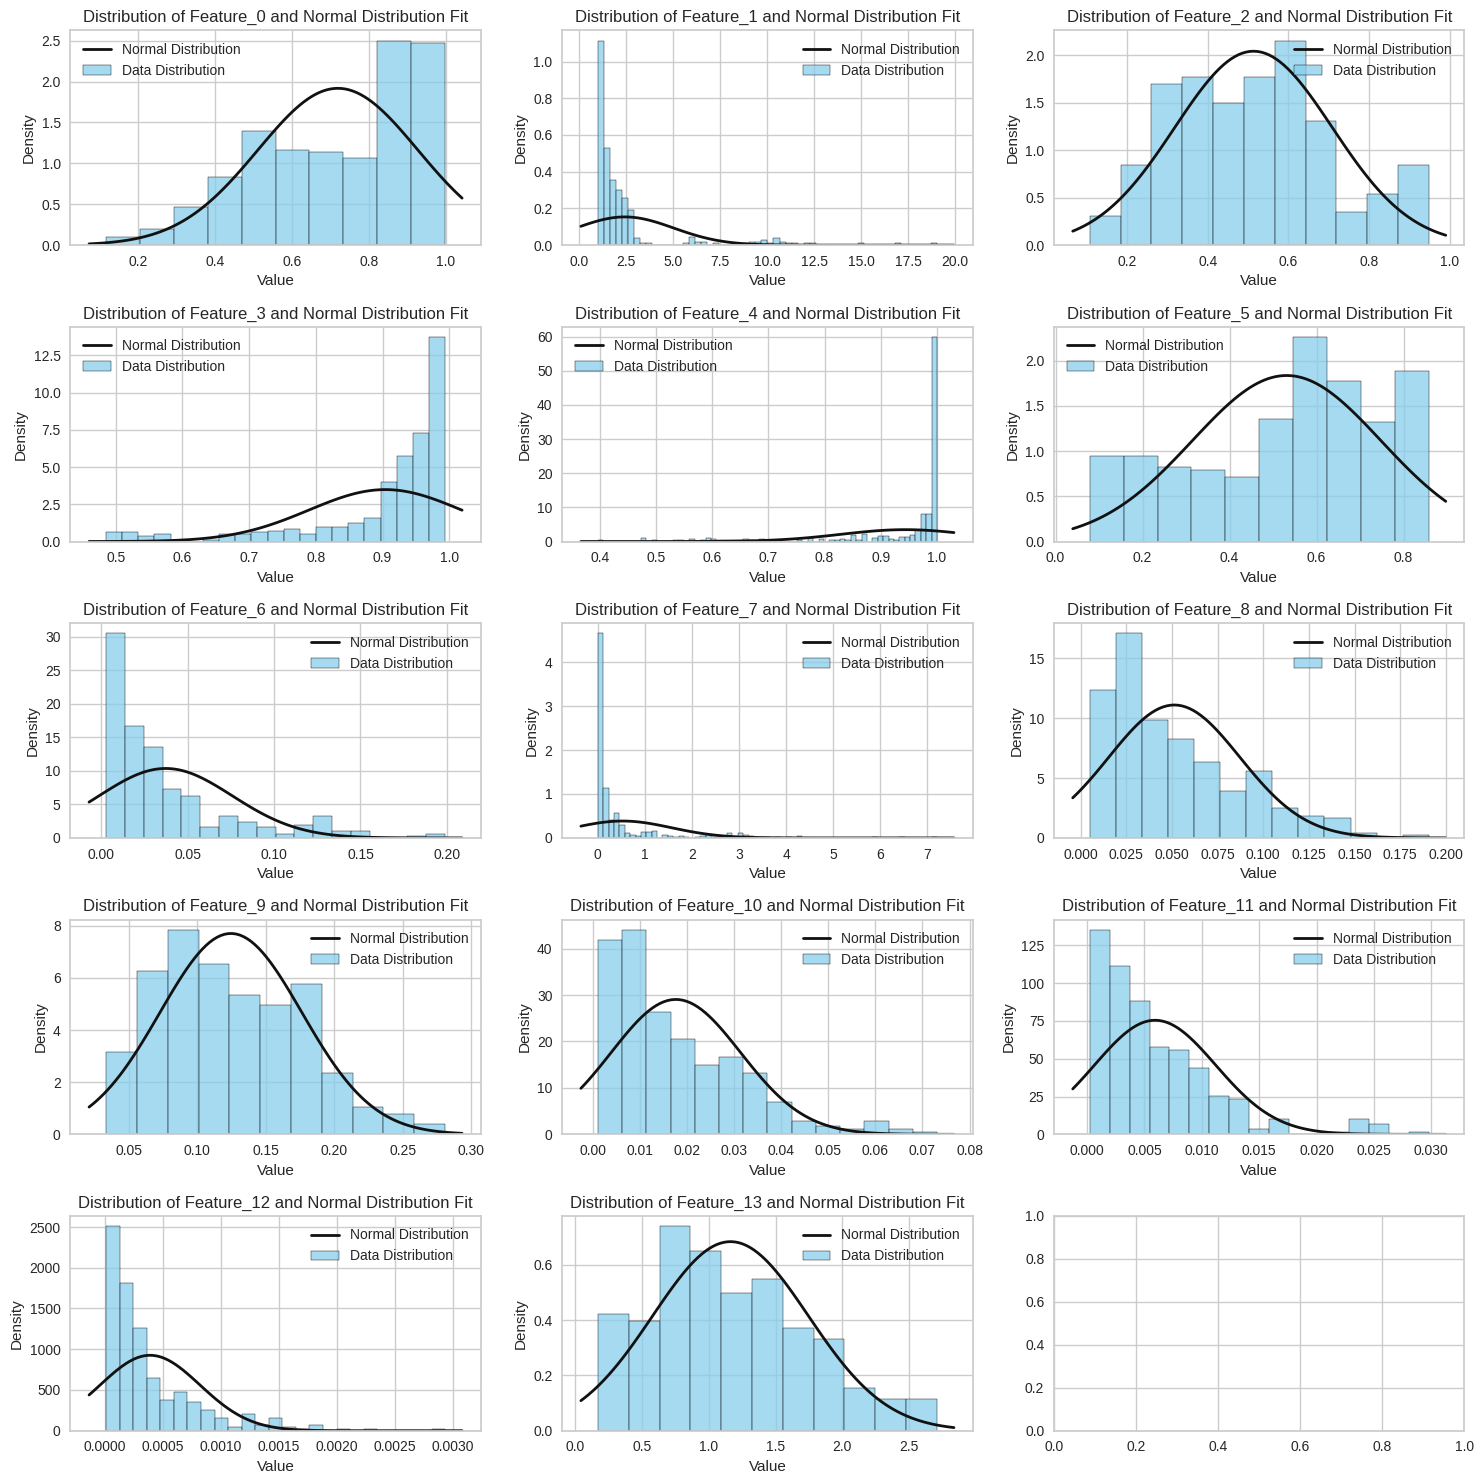

In [43]:
# Plot distributions for all features
num_features = Xcsv.shape[1]
num_subplots_per_row = 3
num_rows = (num_features + num_subplots_per_row - 1) // num_subplots_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=num_subplots_per_row, figsize=(15, 3*num_rows))

for i, column in enumerate(Xcsv.columns):
    row, col = divmod(i, num_subplots_per_row)
    sb.histplot(Xcsv[column], kde=False, stat="density", color='skyblue', ax=axes[row, col], label='Data Distribution')
    mu, std = norm.fit(Xcsv[column])
    xmin, xmax = axes[row, col].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[row, col].plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Density')
    axes[row, col].set_title(f'Distribution of {column} and Normal Distribution Fit')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

<Axes: >

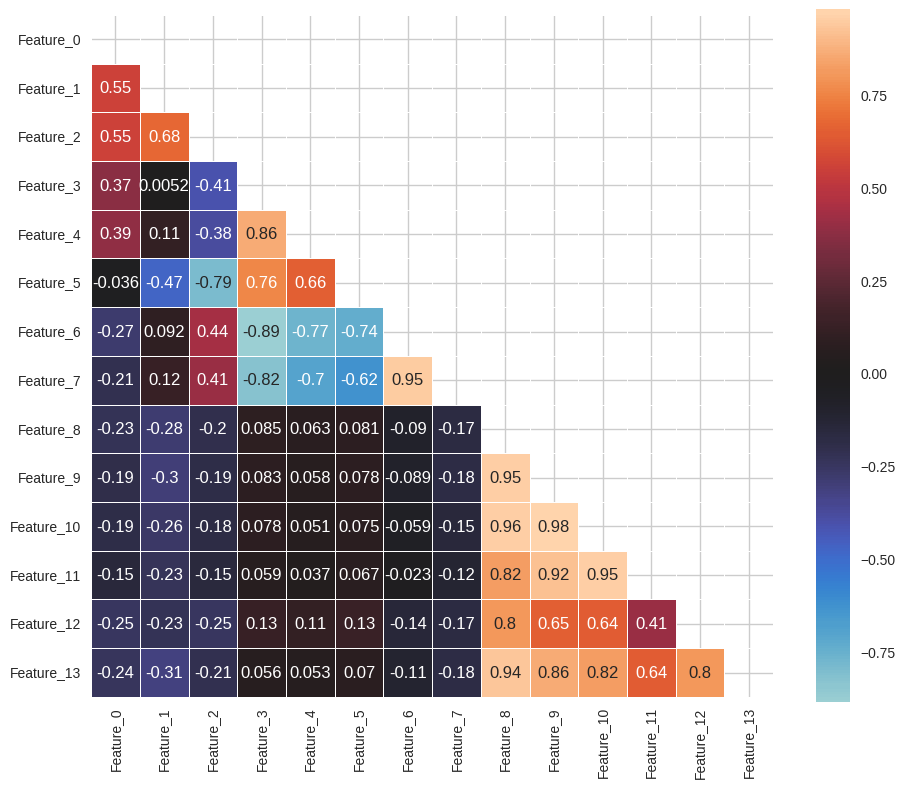

In [44]:
# Compute the correlation matrix
corr = Xcsv.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, annot=True)

In [45]:
def dunn_index(X, labels):
    """
    Calculate the Dunn index for cluster validity.

    Parameters:
    X : ndarray of shape (n_samples, n_features)
        Data points.
    labels : ndarray of shape (n_samples,)
        Cluster labels for each data point.

    Returns:
    float
        Dunn index.
    """
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)

    if num_clusters < 2:
        raise ValueError("There must be at least two clusters to compute the Dunn index.")

    # Compute pairwise distances between all points
    distances = pairwise_distances(X)

    # Compute intra-cluster distances (max distance within a cluster)
    intra_cluster_distances = np.zeros(num_clusters)
    for k in unique_labels:
        cluster_k = X[labels == k]
        if cluster_k.shape[0] > 1:
            intra_cluster_distances[k] = np.max(pairwise_distances(cluster_k))
        else:
            intra_cluster_distances[k] = 0

    # Compute inter-cluster distances (min distance between clusters)
    inter_cluster_distances = np.full((num_clusters, num_clusters), np.inf)
    for i, label_i in enumerate(unique_labels):
        for j, label_j in enumerate(unique_labels):
            if label_i != label_j:
                cluster_i = X[labels == label_i]
                cluster_j = X[labels == label_j]
                inter_cluster_distances[i, j] = np.min(pairwise_distances(cluster_i, cluster_j))

    min_inter_cluster_distance = np.min(inter_cluster_distances)
    max_intra_cluster_distance = np.max(intra_cluster_distances)

    dunn_score = min_inter_cluster_distance / max_intra_cluster_distance
    return dunn_score


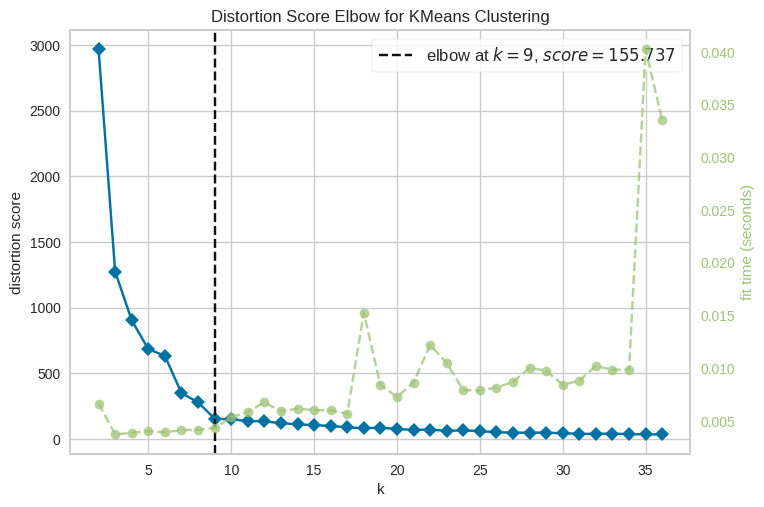

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(2,37))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [48]:
# Clustering
kmeans = KMeans(n_clusters=9)
clusters = kmeans.fit_predict(X)
silhouette = silhouette_score(X, clusters)
dunn = dunn_index(X, clusters)
print(f"{silhouette=}")
print(f"{dunn=}")

silhouette=0.5857667928738991
dunn=0.25080431751723387


In [49]:
df0_img['cluster'] = clusters

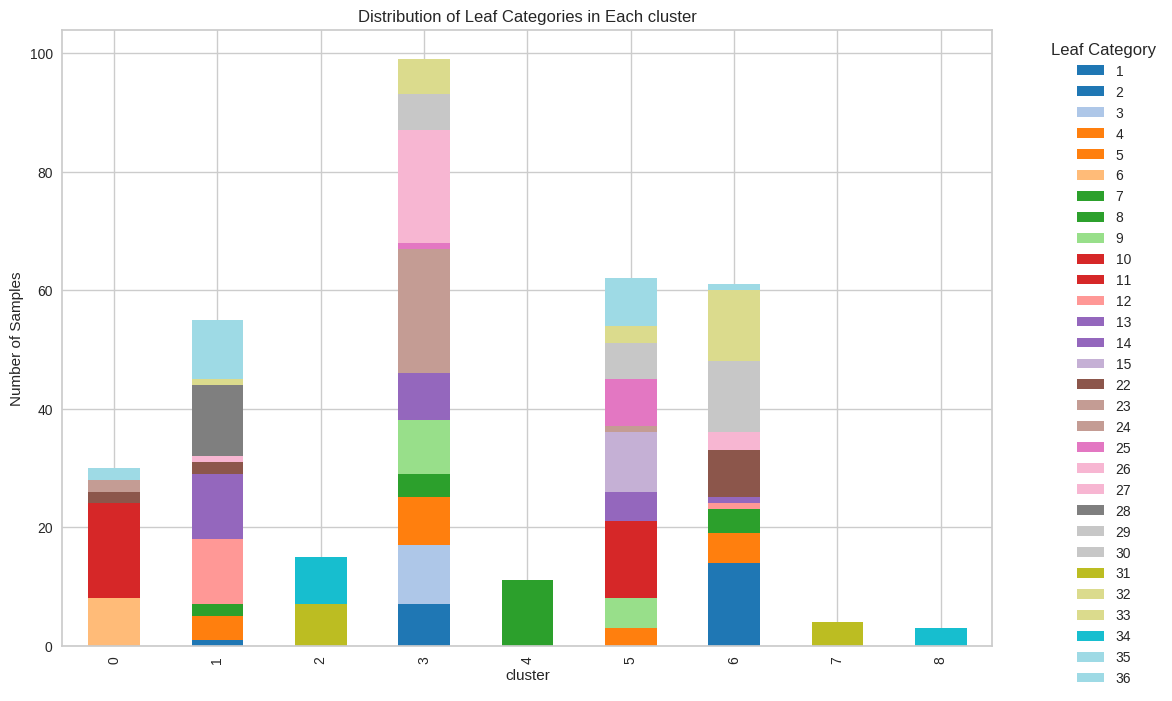

In [50]:
# Create a contingency table of cluster labels vs leaf categories
contingency_table = pd.crosstab(df0_img['cluster'], df0_img['Leaf_Category'])

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.xlabel('cluster')
plt.ylabel('Number of Samples')
plt.title('Distribution of Leaf Categories in Each cluster')
plt.legend(title='Leaf Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

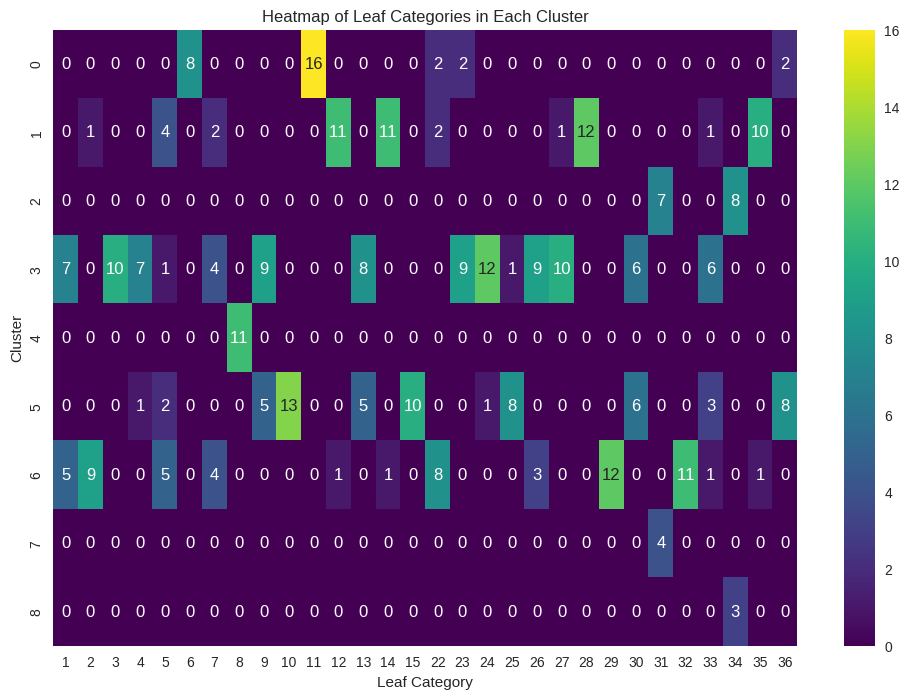

In [51]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(contingency_table, annot=True, cmap='viridis', fmt='d')
plt.xlabel('Leaf Category')
plt.ylabel('Cluster')
plt.title('Heatmap of Leaf Categories in Each Cluster')
plt.show()

In [52]:
X

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,lbp1,lbp2,lbp3,lbp4,lbp5,lbp6,lbp7,lbp8,lbp9,cluster
0,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,...,0.067429,0.033870,0.127487,0.121392,0.177015,0.106872,0.081552,0.132872,0.123950,4
1,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,...,0.067567,0.034446,0.126929,0.122591,0.180153,0.106865,0.080466,0.130027,0.122604,4
2,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,...,0.070252,0.029077,0.122241,0.104575,0.174168,0.106722,0.086175,0.147474,0.132255,4
3,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,...,0.073597,0.032444,0.119006,0.103273,0.166819,0.108439,0.086409,0.142263,0.138024,4
4,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,...,0.068578,0.033749,0.126026,0.114907,0.175502,0.106991,0.083772,0.135337,0.126224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,...,0.069433,0.050421,0.129334,0.143908,0.158845,0.106497,0.076236,0.103908,0.122700,5
336,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,...,0.076696,0.061499,0.119271,0.133008,0.133205,0.104010,0.081442,0.098494,0.140119,5
337,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,...,0.071188,0.049936,0.128736,0.139611,0.157663,0.102784,0.077698,0.107771,0.124699,5
338,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,...,0.068396,0.039861,0.126480,0.131509,0.169515,0.110684,0.077212,0.121751,0.122895,7


In [53]:
X = pd.get_dummies(X, columns=['cluster'], drop_first=True, dtype=int)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the sizes
print(f'Training set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')

Training set size: (238, 32)
Test set size: (102, 32)


In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
rf = RandomForestClassifier(n_estimators=500, max_depth=18)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, n_estimators=500)

In [59]:
# Predict on validation and test sets
test_preds = rf.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_preds)

print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8529411764705882


In [60]:
param_dist = {'n_estimators': randint(50,700),
              'max_depth': randint(4,30)}

# Create a random forest classifier
rf = RandomForestClassifier(criterion='entropy')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=20,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
                   n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78fbf1752ce0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78fbef7baf80>})

In [61]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 13, 'n_estimators': 332}


In [62]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8529411764705882


In [63]:
y_pred

array([31, 11, 11,  5, 12,  1, 22, 31, 36,  3, 12, 26, 29, 14, 11, 22, 11,
       35, 30, 32, 31,  6, 15, 11, 13,  9, 11, 25, 13, 34, 22, 27, 10, 34,
        8,  1,  1, 22, 11,  8, 10,  1, 14, 27,  5, 34, 32,  1,  8, 27, 35,
       22, 24,  9,  7, 24,  6, 36, 36,  5, 33, 33, 34, 22,  9,  8,  8,  2,
       12, 11, 27, 13, 35, 28, 33,  8, 13, 24, 29,  7, 10, 30,  9, 30, 13,
        2,  3, 31, 13, 26, 28, 30, 25, 28, 14, 25,  2, 30, 28, 35,  2, 13])

In [65]:
log_reg = LogisticRegression(max_iter=10000, multi_class='ovr')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7843137254901961
